# Extract Building Footprints and Imagery by Region with BRAILS++
This notebook demonstrates how to:
1. Select a location and create a region boundary.
2. Extract building footprints using a selected scraper.
3. Subsample the inventory for faster processing.
4. Retrieve aerial imagery from Google Satellite.
5. Retrieve street-level imagery from Google Streetview.
6. Display inventory information.

## Install BRAILS++

Before running the following cells, install the BRAILS++ package.  

In [28]:
!pip install brails

In [1]:
from brails import Importer 
from brails.utils import PlotTools

## Step 0: Modify These Variables Before Running the Notebook
- `LOCATION` : Set the target location for image retrieval (e.g., `'Ft Myers Beach, Florida'`).  
- `FOOTPRINT_SCRAPER` : Specify the scraper class to use (e.g., `'OvertureMapsFootprintScraper'`).  
- `API_KEY` : Provide your Google API key for accessing Street View and other services.

In [2]:
LOCATION = 'Ft Myers Beach, Florida'
FOOTPRINT_SCRAPER = 'OvertureMapsFootprintScraper'
API_KEY = 'YOUR-API-KEY-HERE'

## Step 1: Create an `Importer` Instance
`Importer` is BRAILS++’s dynamic class loader. In this example, you will use an `Importer` instance to retrieve different components of the BRAILS++ pipeline such as:
- `RegionBoundary` (to define an area of interest)
- Scrapers like `OvertureMapsFootprintScraper` (to get building footprints)
- Imagery providers like `GoogleSatellite` or `GoogleStreetview`

In [3]:
importer = Importer()

## Step 2: Define the Location and Create a RegionBoundary
The **RegionBoundary** object tells **BRAILS++** the *geographical area* where we want to extract building footprints and/or related data.

**In this example:**
- We obtain the `RegionBoundary` class dynamically using the `Importer` instance (no hardcoded module paths).
- We create a `RegionBoundary` object by passing a dictionary describing the type of location input and the actual data.

**`type` can be one of:**
- `locationName` – a place name, like `'Berkeley, CA'`
- `locationPolygon` – a tuple containing coordinates for a polygon in (lon1, lat1, .... lon_n, lat_n) format

**`data`** holds the actual value for that type.




In [4]:
region_boundary_class = importer.get_class('RegionBoundary')
region_boundary_object = region_boundary_class(
    {'type': 'locationName', 'data': LOCATION})

## Step 3: Create a Footprint Scraper and Retrieve Building Data

In this step, we set up a **scraper** to retrieve building footprints within the previously defined region.

- First, we dynamically obtain the scraper class from the `Importer` by name (stored in the `scraper` variable). This avoids hardcoding class imports and makes it easy to swap different scraper implementations.
- We create an instance of the scraper, passing configuration parameters. Here, `{"length": "ft"}` specifies that all length-related measurements in the results should be reported in **feet**.
- Using the `get_footprints()` method, we request all building footprints inside the `RegionBoundary` defined earlier. The result is stored in an **inventory** object, which contains:
  - Geometry of each building footprint
  - Metadata such as area, length, and possibly height (depending on the scraper)
- Finally, we print a summary of how many assets (buildings) were found in the given location using the selected scraper.

In [8]:
scraper_class = importer.get_class(FOOTPRINT_SCRAPER)
scraper = scraper_class({'length': 'ft'})
inventory = scraper.get_footprints(region_boundary_object)
print(f'Number of assets found: {len(inventory.inventory)} for {LOCATION} '
      f'using {FOOTPRINT_SCRAPER}')

No weight unit specified. Using default: 'lb'.
'overtureRelease' not defined in input. Falling back to latest release: 2025-06-25.0

Searching for Ft Myers Beach, Florida...
Found Fort Myers Beach, Lee County, Florida, 33931, United States


Reading dataset batches: 309it [00:43,  7.17it/s]
Reading dataset batches: 24it [00:03,  7.47it/s]



Finding the assets within the specified area...

Found a total of 3628 assets within the specified area.
Number of assets found: 3628 for Ft Myers Beach, Florida using OvertureMapsFootprintScraper


## Step 4: Subsample the Inventory for Quick Processing

The **inventory** may contain hundreds or even thousands of buildings, depending on the size and density of the selected region.

To keep this example lightweight and fast:
- We randomly select a fixed number of buildings from the full inventory using `inventory.get_random_sample(nsamples, seed)`.
- Here: `nsamples=20` means exactly **20 buildings** will be chosen. `seed=40` sets the random seed so that the selection is **repeatable** running the notebook again with the same seed will return the same sample.

In [9]:
small_inventory = inventory.get_random_sample(nsamples=20, seed=40)

## Step 5: Retrieve Aerial Imagery (Google Satellite)
In this cell, we dynamically load and use the `GoogleSatellite` class to fetch satellite images:

1. **Load and instantiate the class**: Retrieve the `GoogleSatellite` class from the `importer` object, allowing dynamic access without a direct import.
2. **Fetch images**: Use the class instance to download satellite images for the items in `small_inventory` and stores them locally in `'tmp/satellite/'`. The resulting images are saved in `images_satellite` for later use.
3. **Show image information**: Displays metadata and basic information about the downloaded satellite images, helping verify the results.

Images will be saved to: /home/bacetiner/Documents/BrailsPlusPlus/examples/image_downloads/tmp/satellite


Obtaining satellite imagery:   5%|▊              | 1/20 [00:00<00:03,  5.72it/s]

Saved image to tmp/satellite/imsat_26.45597719-81.95615707.jpg
Saved image to tmp/satellite/imsat_26.41913335-81.90295329.jpg
Saved image to tmp/satellite/imsat_26.4283135-81.91183942.jpg


Obtaining satellite imagery:  75%|██████████▌   | 15/20 [00:00<00:00, 63.95it/s]

Saved image to tmp/satellite/imsat_26.40471145-81.8898671.jpg
Saved image to tmp/satellite/imsat_26.44734493-81.93429218.jpg
Saved image to tmp/satellite/imsat_26.43401335-81.91244755.jpg
Saved image to tmp/satellite/imsat_26.43499185-81.91305843.jpg
Saved image to tmp/satellite/imsat_26.44326242-81.93168059.jpg
Saved image to tmp/satellite/imsat_26.43717676-81.91710814.jpg
Saved image to tmp/satellite/imsat_26.44996798-81.94191637.jpg
Saved image to tmp/satellite/imsat_26.44318332-81.92891042.jpg
Saved image to tmp/satellite/imsat_26.45441042-81.95578494.jpg
Saved image to tmp/satellite/imsat_26.44191645-81.92715696.jpg
Saved image to tmp/satellite/imsat_26.44531452-81.92814592.jpg
Saved image to tmp/satellite/imsat_26.44646482-81.93766507.jpg
Saved image to tmp/satellite/imsat_26.45423665-81.95661135.jpg
Saved image to tmp/satellite/imsat_26.43217376-81.91054343.jpg
Saved image to tmp/satellite/imsat_26.41342785-81.8986444.jpg
Saved image to tmp/satellite/imsat_26.4263986-81.90585497

Obtaining satellite imagery: 100%|██████████████| 20/20 [00:00<00:00, 20.25it/s]

Saved image to tmp/satellite/imsat_26.41823986-81.90237165.jpg
directory: tmp/satellite
images (num images: 20 )

key: 1878 filename: imsat_26.44531452-81.92814592.jpg
key: 2373 filename: imsat_26.40471145-81.8898671.jpg
key: 3595 filename: imsat_26.43401335-81.91244755.jpg
key: 2146 filename: imsat_26.45597719-81.95615707.jpg
key: 130 filename: imsat_26.45441042-81.95578494.jpg
key: 1004 filename: imsat_26.44326242-81.93168059.jpg
key: 1156 filename: imsat_26.44191645-81.92715696.jpg
key: 2722 filename: imsat_26.41913335-81.90295329.jpg
key: 2609 filename: imsat_26.41342785-81.8986444.jpg
key: 2721 filename: imsat_26.41823986-81.90237165.jpg
key: 845 filename: imsat_26.44996798-81.94191637.jpg
key: 525 filename: imsat_26.44646482-81.93766507.jpg
key: 3121 filename: imsat_26.4283135-81.91183942.jpg
key: 1427 filename: imsat_26.43717676-81.91710814.jpg
key: 1135 filename: imsat_26.44318332-81.92891042.jpg
key: 3603 filename: imsat_26.43499185-81.91305843.jpg
key: 3044 filename: imsat_26

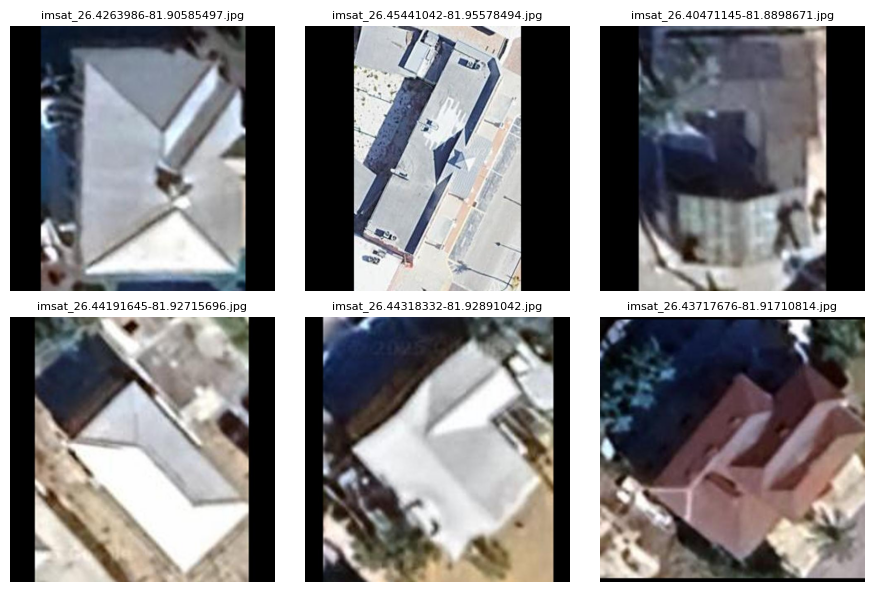

In [10]:
google_satellite = importer.get_class('GoogleSatellite')()
images_satellite = google_satellite.get_images(
    small_inventory, 'tmp/satellite/')

images_satellite.print_info()
PlotTools.plot_images(images_satellite)

## Step 6: Retrieve Street-Level Imagery (Google Street View)

In this cell, we dynamically load and use the `GoogleStreetview` class to fetch street-level images:
1. **Load and instantiate the class**: Retrieve the `GoogleStreetview` class from the `importer` object, allowing dynamic access without a direct import.
2. **Fetch images**: Use the class instance to download street-level images for the items in `small_inventory` and store them locally in `'tmp/street/'`. The resulting images are saved in `images_street` for later use.
3. **Show image information**: Displays metadata and basic information about the downloaded street-level images, helping verify the results.


Images will be saved to: /home/bacetiner/Documents/BrailsPlusPlus/examples/image_downloads/tmp/street



Obtaining street-level imagery: 100%|███████████| 20/20 [00:03<00:00,  5.90it/s]


directory: tmp/street/images
images (num images: 20 )

key: 1878 filename: gstrt_2644531452_-8192814592.jpg properties: {'bdlgLatLon': (26.44531452160854, -81.92814591791038), 'camElev': 3.507968187332153, 'depthMap': 'tmp/street/depthmaps/gdmap_2644531452_-8192814592.txt', 'camLatLon': (26.44513650570534, -81.92798037059433), 'panoBndAngles': array([ 569., 1479.]), 'panoSize': (4096, 2048), 'camHeading': 47.35474014282227, 'panoTilt': 90.59395599365234, 'panoFOV': 45, 'panoRoll': 359.6389770507812}
key: 2373 filename: gstrt_2640471145_-8188986710.jpg properties: {'bdlgLatLon': (26.40471145, -81.8898671), 'camElev': 2.254010677337646, 'depthMap': 'tmp/street/depthmaps/gdmap_2640471145_-8188986710.txt', 'camLatLon': (26.4044096840635, -81.88987582174214), 'panoBndAngles': array([ 796., 1365.]), 'panoSize': (4096, 2048), 'camHeading': 90.86356353759766, 'panoTilt': 90.3420181274414, 'panoFOV': 45, 'panoRoll': 1.555999755859375}
key: 3595 filename: gstrt_2643401335_-8191244755.jpg propert

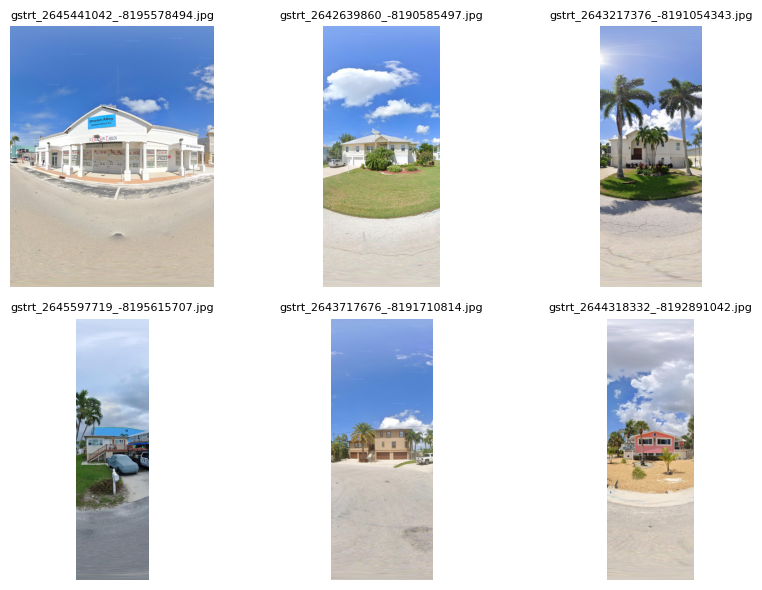

In [12]:
google_street = importer.get_class('GoogleStreetview')({'apiKey': API_KEY})
images_street = google_street.get_images(small_inventory, 'tmp/street/')

images_street.print_info()
PlotTools.plot_images(images_street)